# 제약주의 임상시험 직후 주가 반응 이벤트 스터디

식약처 의약품 임상시험 리스트(link: https://nedrug.mfds.go.kr/searchClinic) 에서 상장기업을 골라낸 뒤 해당 임상시험 허가/불허 날짜를 찾고 분석에 적절한 종목을 선정한다. 
- 임상시험 허가심사 및 임상시험 결과가 미리 예측 가능하지 않아야 하며
- 임상시험 이외의 외부요인에 주가가 영향을 많이 받지 않는 종목이어야 한다. (가령, 의약품 말고도 화장품/마스크 등 다른 사업을 많이 가지고 있는 경우.) 

해당 날짜의 임상 허가/불허 뉴스가 최초 게시된 시각을 알아낸다. (분 단위)

그 시각 전후의 주가를 잘 관찰하여 적절한 estimation window, event window를 설정한다. 

한 종목에서 임상 뉴스에 대한 주가의 반응이 얼마나 빨리, 얼마나 나타나는지, 종목간의 차이는 어떤지 알아본다. 

## 프로젝트의 해결해야 할 이슈

- 현업에서 일반적으로 바이오/제약 관련 이벤트 스터디가 어떻게 이뤄지고 있는지 확인해야 한다. 
- 아카데믹에서 일반적으로 바이오/제약 관련 이벤트 스터디가 어떻게 이뤄지고 있는지 확인해야 한다. 
- 임상시험 허가/불허가 아닌 임상시험 성공/실패 데이터를 구하는 것이 더 영향력이 크고, 중요할 것으로 생각된다. 
    - 관련하여, 금융위는 앞으로는 투자자의 혼란을 막기 위해 '임상시험 성공'이라는 표현을 사용할 수 없게했다. 그 말은 지금까지의 임상시험 성공/실패 관련 기사나 공시에는 객관적으로 성공/실패를 알기 힘든, 오해를 불러일으킬 수 있는 표현이 사용되었다고 해석할 수 있다. (기사 참고: http://biospectator.com/view/news_view.php?varAtcId=9502) 
- 이벤트 스터디와 관련하여, 어떻게 객관적으로 estimation window, event window를 설정하고 임상시험의 효과를 검증할 수 있을지 고민해봐야 한다. 
- 1분단위 고빈도 주가 데이터라는 점을 고려하여 정상수익률 모형을 어떻게 설정해야 하는지 고민해봐야 한다. 

In [68]:
import win32com.client

import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn import preprocessing
import re

### 식약처 임상시험 리스트를 불러온다. 

In [54]:
xlsx = pd.ExcelFile('./data_files/nedrug_mfds_ALL_20120101-20200214.xlsx')
mfds_clinical_trials = pd.read_excel(xlsx, 'Sheet0')
mfds_clinical_trials.columns = ['status', 'client', 'product_name', 'ingredients', 'clinical_trial_title', 'stage', 'is_domestic', 'test_institutions', 'approval_date']
'''
진행현황: status,
의뢰자: client,
제품명: product_name,
성분명: ingredients,
임상시험 제목: clinical_trial_title,
임상시험 단계: stage,
개발지역: is_domestic,
실시기관: test_institutions,
승인일: approval_date,
'''
mfds_clinical_trials.head()

,status,client,product_name,ingredients,clinical_trial_title,stage,is_domestic,test_institutions,approval_date
0,승인완료,경희대학교병원,콜리스 주 Colis Inj.(품목기준코드: 201200983),콜리스틴메탄설포네이트나트륨,건강한 자원자를 대상으로 Colistin 약동학 평가 및 신독성 예측 바이오마커를 ...,연구자 임상시험,국내개발,경희대학교병원,2020-02-14
1,승인완료,유유제약,YY두타스테리드정제(가칭) 0.5mg,YY두타스테리드정제(가칭) 0.5mg,㈜유유제약 “YY두타스테리드정제(가칭) 0.5 mg” 과 ㈜글락소스미스클라인 “아보...,1상,국내개발,에이치플러스 양지병원,2020-02-13
2,승인완료,연세대학교의과대학세브란스병원,pemetrexed,pemetrexed,전이성/재발성 연부조직 육종 환자에서 Pemetrexed/Cisplatin 화학요법...,연구자 임상시험,국내개발,"연세대학교의과대학 강남세브란스병원,재단법인아산사회복지재단서울아산병원,삼성서울병원,연...",2020-02-12
3,승인완료,한양대학교병원,UN03,UN03,섬유화를 동반한 비알코올성 지방간염(NASH) 환자에서 UN03의 안전성 평가 및 ...,연구자 임상시험,국내개발,한양대학교병원,2020-02-12
4,승인완료,에스씨엠생명과학주식회사,SCM-AGH,동종골수유래중간엽줄기세포,ADT2002 시험에 참여했던 시험대상자에서 SCM-AGH에 대한 장기 안전성 추적...,연장,국내개발,"인하대학교의과대학부속병원,강동경희대학교의대병원,건국대학교병원,고려대학교의과대학부속안...",2020-02-11


In [55]:
mfds_clinical_trials.describe()

,status,client,product_name,ingredients,clinical_trial_title,stage,is_domestic,test_institutions,approval_date
count,5674,5674,5674,5536,5673,5674,5649,5608,5674
unique,3,586,3352,2943,5613,18,2,2920,1717
top,승인완료,서울대학교병원,MK-3475,MK-3475,건강한 성인 남성에서 음식물이 JLP-1310의 약동학적 특성에 미치는 영향을 평가...,1상,국내개발,서울대학교병원,2019-09-30
freq,2815,192,64,64,3,1631,3298,341,16


<h5 style='color:red'>TODO: Label Encoding</h5>

In [56]:
mfds_clinical_trials.status.unique()

array(['승인완료', '모집완료', '종료'], dtype=object)

In [57]:
mfds_clinical_trials.is_domestic.unique()

array(['국내개발', '국외개발', nan], dtype=object)

In [58]:
mfds_clinical_trials.approval_date = pd.to_datetime(mfds_clinical_trials.approval_date, format='%Y-%m-%d')
mfds_clinical_trials.head()

,status,client,product_name,ingredients,clinical_trial_title,stage,is_domestic,test_institutions,approval_date
0,승인완료,경희대학교병원,콜리스 주 Colis Inj.(품목기준코드: 201200983),콜리스틴메탄설포네이트나트륨,건강한 자원자를 대상으로 Colistin 약동학 평가 및 신독성 예측 바이오마커를 ...,연구자 임상시험,국내개발,경희대학교병원,2020-02-14
1,승인완료,유유제약,YY두타스테리드정제(가칭) 0.5mg,YY두타스테리드정제(가칭) 0.5mg,㈜유유제약 “YY두타스테리드정제(가칭) 0.5 mg” 과 ㈜글락소스미스클라인 “아보...,1상,국내개발,에이치플러스 양지병원,2020-02-13
2,승인완료,연세대학교의과대학세브란스병원,pemetrexed,pemetrexed,전이성/재발성 연부조직 육종 환자에서 Pemetrexed/Cisplatin 화학요법...,연구자 임상시험,국내개발,"연세대학교의과대학 강남세브란스병원,재단법인아산사회복지재단서울아산병원,삼성서울병원,연...",2020-02-12
3,승인완료,한양대학교병원,UN03,UN03,섬유화를 동반한 비알코올성 지방간염(NASH) 환자에서 UN03의 안전성 평가 및 ...,연구자 임상시험,국내개발,한양대학교병원,2020-02-12
4,승인완료,에스씨엠생명과학주식회사,SCM-AGH,동종골수유래중간엽줄기세포,ADT2002 시험에 참여했던 시험대상자에서 SCM-AGH에 대한 장기 안전성 추적...,연장,국내개발,"인하대학교의과대학부속병원,강동경희대학교의대병원,건국대학교병원,고려대학교의과대학부속안...",2020-02-11


In [59]:
mfds_clinical_trials.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5674 entries, 0 to 5673
Data columns (total 9 columns):
status                  5674 non-null object
client                  5674 non-null object
product_name            5674 non-null object
ingredients             5536 non-null object
clinical_trial_title    5673 non-null object
stage                   5674 non-null object
is_domestic             5649 non-null object
test_institutions       5608 non-null object
approval_date           5674 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(8)
memory usage: 221.7+ KB


### 대신증권 CYBOS API를 이용해 종목코드 반환

상장되지 않은 client는 자동으로 제외한다. 

In [60]:
## 식약처 client는 xxx(주), xxx주식회사 형식인 경우가 있음. 정식 종목명에선 없어야 한다.

def stock_name_parser(name):
    if '(주)' in name:
        return name.strip('(주)')
    elif '주식회사' in name:
        return name.strip('주식회사')
    else:
        return name

In [61]:
## CYBOS와 연결 확인

instCpCybos = win32com.client.Dispatch("CpUtil.CpCybos")
print(instCpCybos.IsConnect) # 1이면 성공

1


In [62]:
instCpStockCode = win32com.client.Dispatch("CpUtil.CpStockCode")

In [63]:
def stock_name2ticker(name):
    ticker = instCpStockCode.NameToCode(name)
    if ticker == '':
        return None
    else:
        return ticker

In [64]:
mfds_clinical_trials['ticker'] = mfds_clinical_trials.client.apply(stock_name_parser).apply(stock_name2ticker)
mfds_clinical_trials.ticker.head()

0       None
1    A000220
2       None
3       None
4       None
Name: ticker, dtype: object

In [65]:
mfds_clinical_trials = mfds_clinical_trials.dropna(subset=['ticker'])
mfds_clinical_trials.head()

,status,client,product_name,ingredients,clinical_trial_title,stage,is_domestic,test_institutions,approval_date,ticker
1,승인완료,유유제약,YY두타스테리드정제(가칭) 0.5mg,YY두타스테리드정제(가칭) 0.5mg,㈜유유제약 “YY두타스테리드정제(가칭) 0.5 mg” 과 ㈜글락소스미스클라인 “아보...,1상,국내개발,에이치플러스 양지병원,2020-02-13,A000220
7,승인완료,(주)유한양행,YHP1906,YHP1906,YHP1906정 5밀리그램과 YHR1902정 5밀리그램의 생물학적동등성 평가를 위한...,1상,국내개발,"인산의료재단 메트로병원,바이오코아(주)",2020-02-11,A000100
8,승인완료,동아에스티(주),동아아토르바스타틴정80밀리그램(아토르바스타틴칼슘삼수화물),아토르바스타틴칼슘삼수화물,"동아에스티㈜ ""동아아토르바스타틴정80밀리그램(아토르바스타틴칼슘삼수화물)""과 한국화이...",1상,국내개발,"바이오코아(주),에이치플러스 양지병원",2020-02-11,A170900
12,승인완료,동아에스티(주),슈가논정5밀리그램(에보글립틴타르타르산염),에보글립틴타르타르산염(DA-1229),Metformin과 evogliptin 병용 요법으로 혈당 조절이 불충분한 제2형 ...,3상,국내개발,"한림대학교 성심병원,의료법인명지의료재단명지병원,가톨릭대학교부천성모병원,학교법인가톨릭...",2020-02-07,A170900
15,승인완료,환인제약(주),팔페리돈서방정6밀리그램(팔리페리돈),팔리페리돈,환인제약㈜의 “팔페리돈서방정 6밀리그램(팔리페리돈)”과 ㈜한국얀센의 “인베가서방정 ...,1상,국내개발,"베스티안병원,바이오코아(주)",2020-02-07,A016580


In [155]:
mfds_clinical_trials.to_pickle('./data_files/mfds_clinical_trials.pkl')

### Example: 2월 7일 동아에스티 3상 승인

In [70]:
instStockChart = win32com.client.Dispatch('CPSysDib.StockChart')
ticker = 'A170900' # 동아에스티(주)

In [82]:
# 종목과 조회조건 등을 설정. 

instStockChart.SetInputValue(0, ticker) # 첫 인자는 데이터 타입, 두 번째 인자는 입력 데이터 값. 0은 종목코드, A003540은 종목코드. 
instStockChart.SetInputValue(1, ord('2')) # 첫 번째 인자는 기간/요청 설정을 말하는 1. 두 번째 인자는 기간으로 요청 시 1, 개수로 요청시 2. 

instStockChart.SetInputValue(2, '20200207')

instStockChart.SetInputValue(4, 1000) # 첫 번째 인자는 요청개수 설정을 말하는 4. 두 번째 인자는 실제로 몇 개 요청할 것인지 개수. (여기선 10개)
instStockChart.SetInputValue(5, [0, 1, 2, 3, 4, 5, 8]) # 첫 번째 인자는 요청할 데이터의 종류를 말하는 5. 두 번째 인자는 어떤 인자를 요청할 지. 5는 종가. 
instStockChart.SetInputValue(6, ord('m')) # 첫 번째 인자는 차트의 종류를 말하는 6. 두 번째 인자는 어떤 차트인지. ord('D')는 일단위
instStockChart.SetInputValue(9, ord('1')) # 첫 번째 인자는 수정주가의 반영여부를 말하는 9, 두 번째 인자는 수정주가를 의미하는 ord('1')

In [83]:
instStockChart.BlockRequest()

0

In [84]:
print("""
Header information

Ticker: {ticker}
Field names: {field_names}
Data count: {data_count}
""".format(
    ticker=instStockChart.GetHeaderValue(0),
    field_names=instStockChart.GetHeaderValue(2),
    data_count=instStockChart.GetHeaderValue(3),
))



Header information

Ticker: A170900
Field names: ('날짜', '시간', '시가', '고가', '저가', '종가', '거래량')
Data count: 1000



In [85]:
data_count = instStockChart.GetHeaderValue(3)
fields_count = instStockChart.GetHeaderValue(1)
print(data_count, fields_count)

1000 7


In [86]:
donga_m = []

for i in range(data_count):
    date = instStockChart.GetDataValue(0, i)
    time = instStockChart.GetDataValue(1, i)
    open_price = instStockChart.GetDataValue(2, i)
    high_price = instStockChart.GetDataValue(3, i)
    low_price = instStockChart.GetDataValue(4, i)
    close_price = instStockChart.GetDataValue(5, i)
    volume = instStockChart.GetDataValue(6, i)
    
    row_dic = {}
    row_dic['date'] = date
    row_dic['time'] = time
    row_dic['open'] = open_price
    row_dic['high'] = high_price
    row_dic['low'] = low_price
    row_dic['close'] = close_price
    row_dic['volume'] = volume
    
    donga_m.append(row_dic)

In [87]:
# TODO: 변수 네이밍 바꿔주자 _df 붙일 대상 정하고 time series와 아닌것 구분

donga_ts_m_df = pd.DataFrame(donga_m)
donga_ts_m_df.head()

,date,time,open,high,low,close,volume
0,20200207,1530,94700,94700,94700,94700,1570
1,20200207,1520,94800,94800,94300,94300,411
2,20200207,1519,94900,94900,94900,94900,25
3,20200207,1518,95200,95200,94800,94900,60
4,20200207,1517,94300,95500,94200,95200,1242


In [88]:
donga_ts_m_df.tail()

,date,time,open,high,low,close,volume
995,20200205,1050,92800,92800,92800,92800,1
996,20200205,1049,92800,92800,92800,92800,3
997,20200205,1048,92900,92900,92800,92800,36
998,20200205,1047,92800,92800,92800,92800,46
999,20200205,1046,92900,92900,92800,92800,5


In [89]:
donga_0211 = donga_ts_m_df[donga_ts_m_df.date == 20200207]
donga_0211.head()

,date,time,open,high,low,close,volume
0,20200207,1530,94700,94700,94700,94700,1570
1,20200207,1520,94800,94800,94300,94300,411
2,20200207,1519,94900,94900,94900,94900,25
3,20200207,1518,95200,95200,94800,94900,60
4,20200207,1517,94300,95500,94200,95200,1242


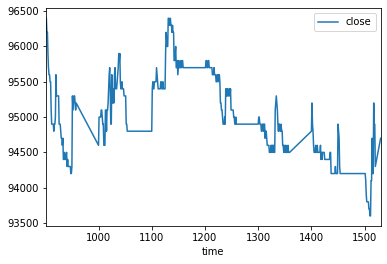

In [90]:
donga_0211.plot(x='time', y='close')

## 프로젝트 방향 수정

### 식약처 임상 승인은 중요한 변수가 아니다. 

2월 7일 동아에스티 관련 기사가 어떤 것이 있는지 알아보기 위해 네이버 뉴스를 검색했지만 임상 승인 관련하여 어떤 기사도 나오지 않았다. 만약 주가에 영향을 주는 호재라면 앞다투어 보도가 되어야 하는데 기사가 한 개도 없는 것이 이상했다. 

게다가 기존 데이터에서 status column을 보면 [승인완료, 모집완료, 종료] 세 가지 값밖에 없다. 승인거부 같은 것은 없다. 이러한 사실들을 토대로 생각했을 때, 식약처 임상 승인은 약의 성공 여부를 판가름하는 것과는 거리가 멀고, 임상 시작 단계의 단순히 행정적인 절차로 보인다. 

한국임상시험포털 K-CLIC 임상시험 진행단계와 절차 설명:
https://www.koreaclinicaltrials.org/kr/contents/kclic_info_04/view.do

### 임상은 쉽사리 성공/실패로 판가름 나지 않는다. 

임상시험 결과는 통계적 유의성을 감안하여 직접 연구 결과를 해결해야 하는 일이다. 쉽게 성공/실패로 나누지 못하며, 결과 해석을 위해선 약학적인 지식이 필요한 것으로 보인다. 

다만, 이론의 여지 없이 악재로 해석할 수 있는 경우도 분명히 존재한다. 가령 2019.08.02 발생한 신라젠 3상 실패 최초 보도 기사는: "신라젠, DMC서 펙사벡 글로벌 임상3상 중단 권고" 와 같은 내용이었는데, 누가 읽어도 사실상의 임상 3상 실패라고 해석할 수 있다. 

기사 링크: http://news.mtn.co.kr/newscenter/news_viewer.mtn?gidx=2019080208315423984 보도시간 08:33

### 중요 긴급 공시는 DART에 나와있다. 

따라서 식약처 임상승인 데이터는 큰 쓸모가 없고, 임상의 성공이나 실패에 관련하여 투자자에게 즉각적인 충격을 주는 데이터 소스를 찾아야 한다. DART에는 중요한 사항에 대한 공시가 빠르게 올라오는 것으로 보인다. 

DART 코스닥 시장 2019.08.02(신라젠 임상3상 실패) 공시: http://dart.fss.or.kr/dsac001/mainK.do?selectDate=2019.08.02&sort=&series=&mdayCnt=0 공시시간 08:23

"투자판단관련주요경영사항 (펙사벡(JX-594)간암 대상 임상 3상시험(PHOCUS) 관려 무용성 평가 결과 확인)"와 같이 나와있다. 

### 공시 시간 != 장중 일 개연성이 높다. 

악재가 장중 발표되면 주가에 즉각적인 영향을 끼치기 때문에 일부러 공시시간을 금요일 저녁에 하거나 장이 열리기 전, 또는 닫힌 직후에 할 것이라고 의심된다. 

분단위 데이터로 event study 시 매일매일의 주식시장 사이에 텀이 있기 때문에 데이터가 불연속적으로 나타난다. 가급적 장중 발표되는 호재/악재를 연구하는 것이 더 좋을 것으로 추측되는 만큼 지진, 화재, 교통사고 등과 같이 상식적으로 시점 조작이 불가능하다 생각되는 사건을 바탕으로 보는 것이 더 좋을 수도 있다는 생각이 든다. 

### Example: 2019.08.02 신라젠 3상 실패

In [135]:
instStockChart = win32com.client.Dispatch('CPSysDib.StockChart')
ticker = instCpStockCode.NameToCode('신라젠')
ticker

'A215600'

In [136]:
# 종목과 조회조건 등을 설정. 

instStockChart.SetInputValue(0, ticker) # 첫 인자는 데이터 타입, 두 번째 인자는 입력 데이터 값. 0은 종목코드, A003540은 종목코드. 
instStockChart.SetInputValue(1, ord('2')) # 첫 번째 인자는 기간/요청 설정을 말하는 1. 두 번째 인자는 기간으로 요청 시 1, 개수로 요청시 2. 

instStockChart.SetInputValue(2, '20190803') 

instStockChart.SetInputValue(4, 1000) # 첫 번째 인자는 요청개수 설정을 말하는 4. 두 번째 인자는 실제로 몇 개 요청할 것인지 개수. (여기선 10개)
instStockChart.SetInputValue(5, [0, 1, 2, 3, 4, 5, 8]) # 첫 번째 인자는 요청할 데이터의 종류를 말하는 5. 두 번째 인자는 어떤 인자를 요청할 지. 5는 종가. 
instStockChart.SetInputValue(6, ord('m')) # 첫 번째 인자는 차트의 종류를 말하는 6. 두 번째 인자는 어떤 차트인지. ord('D')는 일단위
instStockChart.SetInputValue(9, ord('1')) # 첫 번째 인자는 수정주가의 반영여부를 말하는 9, 두 번째 인자는 수정주가를 의미하는 ord('1')

In [137]:
instStockChart.BlockRequest()

0

In [138]:
print("""
Header information

Ticker: {ticker}
Field names: {field_names}
Data count: {data_count}
""".format(
    ticker=instStockChart.GetHeaderValue(0),
    field_names=instStockChart.GetHeaderValue(2),
    data_count=instStockChart.GetHeaderValue(3),
))



Header information

Ticker: A215600
Field names: ('날짜', '시간', '시가', '고가', '저가', '종가', '거래량')
Data count: 1000



In [139]:
data_count = instStockChart.GetHeaderValue(3)
fields_count = instStockChart.GetHeaderValue(1)
print(data_count, fields_count)

1000 7


In [140]:
sillajen_m = []

for i in range(data_count):
    date = instStockChart.GetDataValue(0, i)
    time = instStockChart.GetDataValue(1, i)
    open_price = instStockChart.GetDataValue(2, i)
    high_price = instStockChart.GetDataValue(3, i)
    low_price = instStockChart.GetDataValue(4, i)
    close_price = instStockChart.GetDataValue(5, i)
    volume = instStockChart.GetDataValue(6, i)
    
    row_dic = {}
    row_dic['date'] = date
    row_dic['time'] = time
    row_dic['open'] = open_price
    row_dic['high'] = high_price
    row_dic['low'] = low_price
    row_dic['close'] = close_price
    row_dic['volume'] = volume
    
    sillajen_m.append(row_dic)

In [141]:
# TODO: 변수 네이밍 바꿔주자 _df 붙일 대상 정하고 time series와 아닌것 구분

sillajen_ts_m_df = pd.DataFrame(sillajen_m)
sillajen_ts_m_df.head()

,date,time,open,high,low,close,volume
0,20190802,1530,31200,31200,31200,31200,2075
1,20190802,1520,31200,31200,31200,31200,630
2,20190802,1519,31200,31200,31200,31200,17
3,20190802,1518,31200,31200,31200,31200,48
4,20190802,1517,31200,31200,31200,31200,351


In [142]:
sillajen_ts_m_df.date = pd.to_datetime(sillajen_ts_m_df.date, format='%Y%m%d')
sillajen_ts_m_df.time = pd.to_datetime(sillajen_ts_m_df.time, format='%H%M').dt.time
sillajen_ts_m_df.head()

,date,time,open,high,low,close,volume
0,2019-08-02,15:30:00,31200,31200,31200,31200,2075
1,2019-08-02,15:20:00,31200,31200,31200,31200,630
2,2019-08-02,15:19:00,31200,31200,31200,31200,17
3,2019-08-02,15:18:00,31200,31200,31200,31200,48
4,2019-08-02,15:17:00,31200,31200,31200,31200,351


date와 time의 type이 일치하지 않는다. 둘 다 str으로 바꾼 뒤 합쳐 다시 datetime으로 파싱시키겠다.

In [143]:
sillajen_ts_m_df['datetime'] = pd.to_datetime(sillajen_ts_m_df.date.astype(str) + ' ' + sillajen_ts_m_df.time.astype(str))
sillajen_ts_m_df = sillajen_ts_m_df.drop(['date', 'time'], axis=1)
sillajen_ts_m_df = sillajen_ts_m_df.set_index('datetime')
sillajen_ts_m_df.head()

,open,high,low,close,volume
datetime,,,,,
2019-08-02 15:30:00,31200,31200,31200,31200,2075
2019-08-02 15:20:00,31200,31200,31200,31200,630
2019-08-02 15:19:00,31200,31200,31200,31200,17
2019-08-02 15:18:00,31200,31200,31200,31200,48
2019-08-02 15:17:00,31200,31200,31200,31200,351


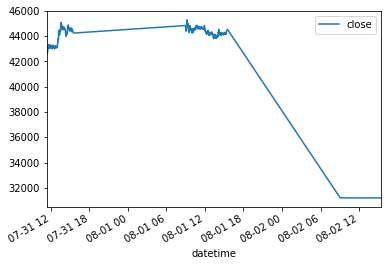

In [144]:
sillajen_ts_m_df.plot(y='close')

In [153]:
sillajen_0801 = sillajen_ts_m_df[(sillajen_ts_m_df.index >= pd.Timestamp(2019, 8, 1, 8, 30)) & (sillajen_ts_m_df.index <= pd.Timestamp(2019, 8, 1, 15, 30))]
sillajen_0801.head()

,open,high,low,close,volume
datetime,,,,,
2019-08-01 15:30:00,44550,44550,44550,44550,30566
2019-08-01 15:20:00,44300,44350,44250,44350,3631
2019-08-01 15:19:00,44250,44350,44200,44300,7319
2019-08-01 15:18:00,44200,44250,44200,44200,1467
2019-08-01 15:17:00,44200,44250,44150,44200,5818


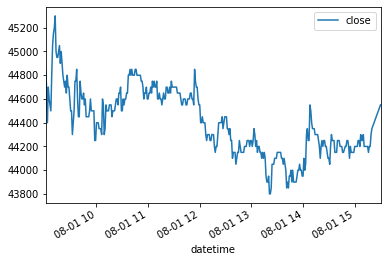

In [154]:
sillajen_0801.plot(y='close')

In [149]:
sillajen_0802 = sillajen_ts_m_df[(sillajen_ts_m_df.index >= pd.Timestamp(2019, 8, 2, 8, 30)) & (sillajen_ts_m_df.index <= pd.Timestamp(2019, 8, 2, 15, 30))]
sillajen_0802.head()

,open,high,low,close,volume
datetime,,,,,
2019-08-02 15:30:00,31200,31200,31200,31200,2075
2019-08-02 15:20:00,31200,31200,31200,31200,630
2019-08-02 15:19:00,31200,31200,31200,31200,17
2019-08-02 15:18:00,31200,31200,31200,31200,48
2019-08-02 15:17:00,31200,31200,31200,31200,351


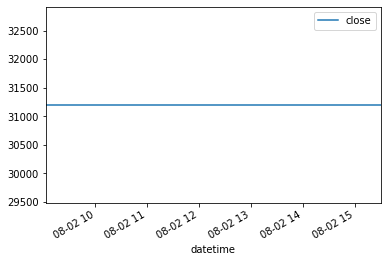

In [151]:
sillajen_0802.plot(y='close')

신라젠은 장이 열리기 전 쇼크가 왔기 때문에 장이 열리기 전 이미 하한가를 맞고 8월 2일 당일 주가가 변동이 없는 것을 관찰할 수 있다. 